In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import scipy.stats as stats
import seaborn as sns
import pandas as pd

This is based on the [homework of week 2](https://github.com/rmcelreath/statrethinking_winter2019/blob/master/homework/week02.pdf) of Statistical Rethinking book material.
I do the homework based on the questions but not following a specific order.
<br>
<br>
A good reference for [Prior and Posterior Predictive Checks](https://docs.pymc.io/notebooks/posterior_predictive.html) in PyMC3.
<br>
<br>
The reference dataset is the [Kalahari !Kung San people](https://www.tensorflow.org/datasets/catalog/howell).

Loading the !Kung dataset

In [2]:
df = pd.read_csv("../data/Howell1.csv", sep=";")
df.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


Taking a look at the range of ages of the dataset.

<AxesSubplot:xlabel='age'>

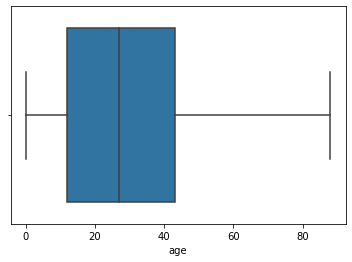

In [3]:
sns.boxplot(df['age'])

## Simple Linear Regression model

Creating a model.
As for the priors **a** is the height for when the weight is equal to the mean of weights.<br> 
As the dataset is composed mainly of teenagers and adults, I chose the mean of height as 150cm with a standard deviation of 20cm, which means that 95% of the heights are concentrated between 110cm and 190cm.   
<br>
Doing a simple regression we have the following:

In [4]:
x_bar = df['weight'].mean()

with pm.Model() as m_1:
    a = pm.Normal('a', 150, 20)
    bW = pm.Normal('bW', 0, 5)
    
    sigma = pm.Exponential('sigma', 1)
    
    mu = pm.Deterministic('mu', a + bW*(df['weight']) - x_bar)
    height = pm.Normal('height', mu=mu, sigma=sigma, observed=df['height'])
    
    m1_trace = pm.sample(tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bW, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:03<00:00, 2881.94draws/s]


In [5]:
varnames = ['~mu']
az.summary(m1_trace, varnames, round_to=2, kind="stats")

/home/elisio/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%
a,111.20,1.07,109.15,113.14
bW,1.76,0.03,1.71,1.81
sigma,9.31,0.29,8.79,9.86


In [6]:
mu_pred = m1_trace['mu']
mu_mean = mu_pred.mean(0)

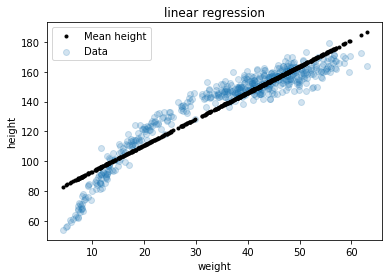

In [7]:
plt.scatter(df.weight, df.height, alpha=0.2, label='Data')
plt.plot(df.weight, mu_mean, '.', color='black', label='Mean height')
plt.title('linear regression')
plt.xlabel('weight')
plt.ylabel('height')
plt.legend()

Not a good fit as we can see.

---

## Improving with the log(weight)
Model the relationship between height(cm) and the natural logarithm of weight(log-kg)

In [8]:
df['weight_log'] = np.log(df['weight'])
df.head()

,height,weight,age,male,weight_log
0,151.765,47.825606,63.0,1,3.867561
1,139.700,36.485807,63.0,0,3.596923
2,136.525,31.864838,65.0,0,3.461503
3,156.845,53.041915,41.0,1,3.971082
4,145.415,41.276872,51.0,0,3.720302


In [9]:
x_bar = df['weight_log'].mean()

with pm.Model() as m_2:
    a = pm.Normal('a', 150, 20)
    bW = pm.Lognormal('bW', 0, 5)
    
    mu = pm.Deterministic('mu', a + bW*(df['weight_log'] - x_bar))
    sigma = pm.Exponential('sigma', 1)
    
    height = pm.Normal('height', mu=mu, sigma=sigma, observed=df['height'])
    
    m2_trace = pm.sample(tune=4000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bW, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 18000/18000 [00:03<00:00, 4676.10draws/s]


In [10]:
varnames = ["~mu"]
az.summary(m2_trace, varnames, round_to=2, kind="stats")

/home/elisio/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%
a,138.26,0.22,137.84,138.65
bW,47.09,0.39,46.33,47.81
sigma,5.13,0.15,4.82,5.40


In [11]:
mu_pred = m2_trace['mu']
mu_mean = mu_pred.mean(0)

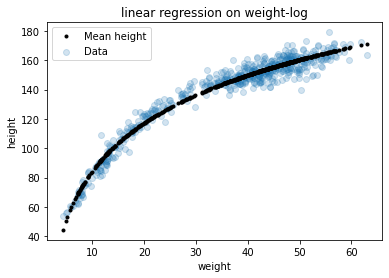

In [12]:
plt.scatter(df.weight, df.height, alpha=0.2, label='Data')
plt.plot(df.weight, mu_mean, '.', color='black', label='Mean height')
plt.title('linear regression on weight-log')
plt.xlabel('weight')
plt.ylabel('height')
plt.legend()

---

## Polynomial regression model

When working with polynomials the first thing to do is standardize the predictor variable. This way we avoid numerical glitches for working with very large numbers.

In [13]:
df['weight_std'] = (df['weight'] - df['weight'].mean()) / df['weight'].std()
df['weight_std2'] = np.power(df['weight_std'], 2)

x_bar = df['weight_std'].mean()

with pm.Model() as m_3:
    a = pm.Normal('a', 150, 20)
    bW = pm.Lognormal('bW', 0, 5)
    cW = pm.Normal('cW', 0, 5)
    
    mu = pm.Deterministic('mu', a + bW*(df['weight_std'] - x_bar) + cW*df['weight_std2'])
    sigma = pm.Exponential('sigma', 1)
    
    height = pm.Normal('height', mu=mu, sigma=sigma, observed=df['height'])
    
    m3_trace = pm.sample(tune=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, cW, bW, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 22000/22000 [00:06<00:00, 3213.62draws/s]


In [14]:
varnames = ["~mu"]
az.summary(m3_trace, varnames, round_to=2, kind="stats")

/home/elisio/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%
a,146.65,0.38,145.98,147.38
cW,-8.39,0.29,-8.96,-7.86
bW,21.42,0.29,20.88,21.95
sigma,5.74,0.17,5.41,6.05


In [15]:
mu_pred = m3_trace['mu']
mu_mean = mu_pred.mean(0)

Text(0, 0.5, 'height')

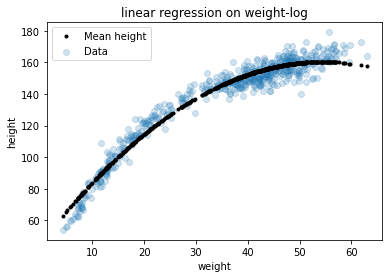

In [16]:
plt.scatter(df.weight, df.height, alpha=0.2, label='Data')
plt.plot(df.weight, mu_mean, '.', color='black', label='Mean height')
plt.title('linear regression on weight-log')
plt.legend()
plt.xlabel('weight')
plt.ylabel('height')

In [17]:
with m_3:
    height_pred = pm.sample_posterior_predictive(trace=m3_trace, vars=[height], size=200)

100%|██████████| 2000/2000 [00:06<00:00, 298.58it/s]


/home/elisio/anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,
/home/elisio/anaconda3/lib/python3.7/site-packages/arviz/data/base.py:153: UserWarning: More chains (2000) than draws (200). Passed array should have shape (chains, draws, *shape)
  UserWarning,


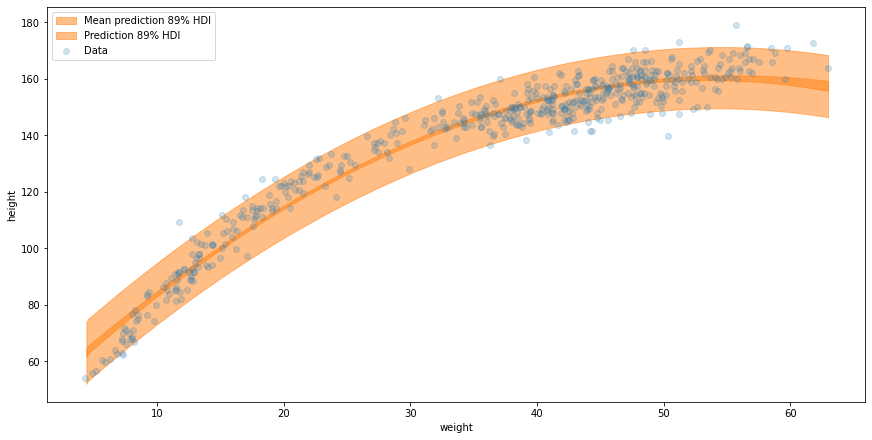

In [18]:
ax = az.plot_hdi(df.weight, mu_pred, hdi_prob=0.89, fill_kwargs={"label": "Mean prediction 89% HDI"}, figsize=(12,6))
az.plot_hdi(df.weight, height_pred['height'], ax=ax, fill_kwargs={"label": "Prediction 89% HDI"}, figsize=(12,6))
plt.scatter(df.weight, df.height, alpha=0.2, label="Data")
#plt.plot(df.weight, mu_mean, '.', color='black')
plt.xlabel('weight')
plt.ylabel('height')
plt.legend()

---

## Checking priors
Doing some prior analysis.

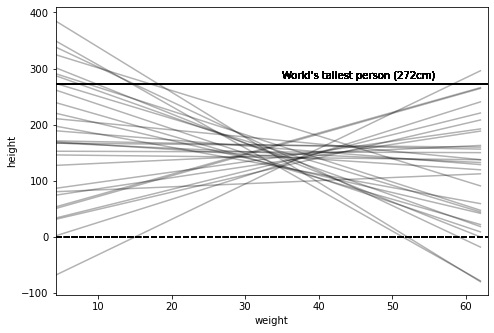

In [19]:
N = 30
a = stats.norm.rvs(150, 20, N)
b = stats.norm.rvs(0, 5, N)
c = stats.norm.rvs(0, 5, N)

x = np.linspace(int(df['weight'].min()), int(df['weight'].max()), 100)
x_bar = df['weight'].mean()

fig = plt.figure()
a1 = fig.add_axes([0,0,1,1])

for i in range(N):
    pred = a[i] + b[i]*(x-x_bar) 
    
    a1.set_xlim(df.weight.min(), df.weight.max())
    a1.plot(x, pred, c='black', alpha=0.3)
    a1.set_xlabel('weight')
    a1.set_ylabel('height')
    a1.axhline(0, c="k", ls="--", label="embryo")
    a1.axhline(272, c="k")
    a1.text(x=35, y=282, s="World's tallest person (272cm)")


By simulating some priors we can clearly notice some problems and how they can be improved. First the correlation between weight and height should be positive. Then, there're negative and impossible heights for humans.<br>

As in the book I included two reference lines, one for height 0 and another for height of 272 cm which corresponds to the world's tallest person.<br>

By using a log-normal distribution we can solve the negative correlations as it restricts the values to positive. 

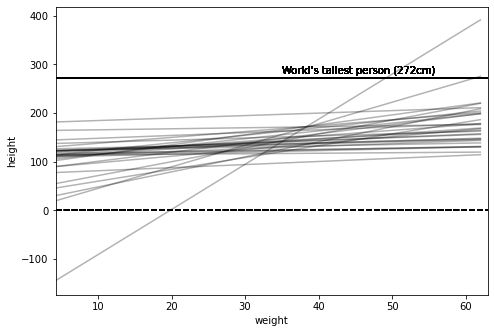

In [20]:
b = stats.lognorm.rvs(s=1, scale=1, size=N)

fig = plt.figure()
a1 = fig.add_axes([0,0,1,1])

for i in range(N):
    pred = a[i] + b[i]*(x-x_bar) 
    a1.set_xlim(df.weight.min(), df.weight.max())
    a1.plot(x, pred, c='black', alpha=0.3)
    a1.set_xlabel('weight')
    a1.set_ylabel('height')
    a1.axhline(0, c="k", ls="--", label="embryo")
    a1.axhline(272, c="k")
    a1.text(x=35, y=282, s="World's tallest person (272cm)")
   

PyMC3 also features a function to sample from the prior predictive.

In [21]:
with m_2:
    priors = pm.sample_prior_predictive()

In [22]:
priors.keys()

dict_keys(['bW', 'sigma_log__', 'mu', 'bW_log__', 'a', 'sigma', 'height'])

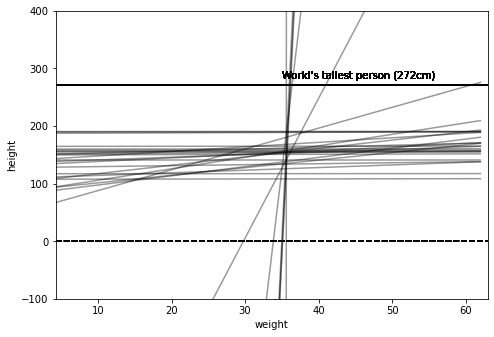

In [23]:
fig = plt.figure()
a1 = fig.add_axes([0,0,1,1])
  

for a_, bW_ in zip(priors["a"][:30], priors["bW"][:30]):
    pred = a_+ bW_ * (x-x_bar)
    a1.plot(x, pred, c="black", alpha=0.4)
    
    a1.set_xlim(df.weight.min(), df.weight.max())
    a1.set_ylim(-100, 400)
    a1.set_xlabel('weight')
    a1.set_ylabel('height')
    a1.axhline(0, c="k", ls="--", label="embryo")
    a1.axhline(272, c="k")
    a1.text(x=35, y=282, s="World's tallest person (272cm)")
 

---

## Some predictions
Making some predictions of height and 89% interval, with the model, for the table below.

Table to be filled with predictions

In [24]:
df_pred = pd.DataFrame({'individual':[1 , 2, 3, 4, 5],
                        'weight':[45, 40, 65, 31, 53],
                        'exp_height':[0, 0, 0, 0, 0],
                        'interval_89':['', '', '', '', '']})
df_pred

,individual,weight,exp_height,interval_89
0,1,45,0,
1,2,40,0,
2,3,65,0,
3,4,31,0,
4,5,53,0,


Below we fill the table with the predictions for expected height and the 89% interval.

In [25]:
for i in range(df_pred.shape[0]):
    # expected height
    exp_height = m3_trace['a'] + m3_trace['bW']*df_pred['weight'][i]-df.weight.mean() + \
                    m3_trace['cW']*np.power(df_pred['weight'][i]-df.weight.mean(), 2) 
    
    df_pred.loc[i, 'exp_height'] = exp_height.mean()
    
    # 89% interval
    df_pred.loc[i, 'interval_89'] = str(az.hdi(exp_height, hdi_prob=.89))

In [26]:
df_pred

,individual,weight,exp_height,interval_89
0,1,45,335.256666,[277.12895971 384.99002664]
1,2,40,806.275484,[783.14658641 831.25846073]
2,3,65,-5744.649874,[-6172.65582729 -5351.80991874]
3,4,31,596.759879,[573.13600248 615.20557733]
4,5,53,-1291.106347,[-1457.81297503 -1153.30800093]


---

## Summary
Below we can see the graph of each model we tried.

First the simple linear regression model.

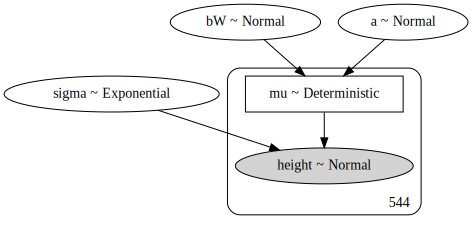

In [27]:
display(pm.model_graph.model_to_graphviz(m_1))

Second the same as the first except for the 'bW' prior as a LogNormal distribution.

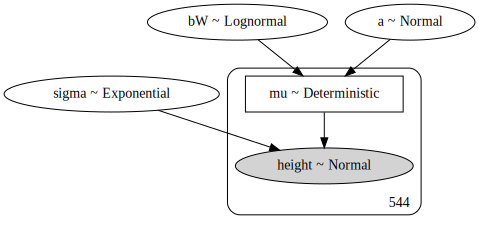

In [28]:
display(pm.model_graph.model_to_graphviz(m_2))

Lastly, the polynomial regression model.

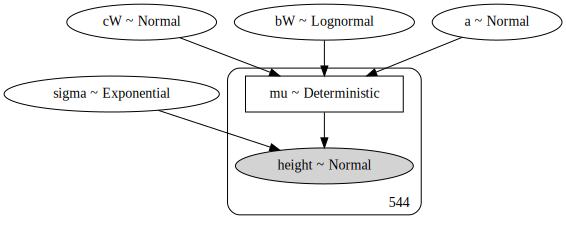

In [29]:
display(pm.model_graph.model_to_graphviz(m_3))

---

---

In [30]:
%load_ext watermark
%watermark -iv -v -nuw

numpy   1.19.1
pandas  1.1.1
pymc3   3.8
arviz   0.10.0
seaborn 0.10.1
last updated: Tue Nov 24 2020 

CPython 3.7.7
IPython 7.17.0
watermark 2.0.2
